In [1]:
from multiprocessing import pool
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import time
import matplotlib.pyplot as plt
import os
import random
from calendar import monthrange

In [238]:
def load_data(pollutant, data_path="data/", time_step=None, time_range=None, season=None, day_of_week=None, time_of_day=None):
    """
    :param pollutant: {"CO", "NO2", "O3", "SO2", "PM10", "PM25"}
    :param data_path: path to data directory
    :param time_step: if provided, {"H", "D", "M", "Y"}
    :param time_range: if provided, get data within the given time_range, inclusive
            If second element isn't provided, defaults to present day
    :param season: if provided, {"winter", "spring", "summer", "autumn"} for seasonal buckets
            Winter: December, January, Ferbruary
            Spring: March, April and May
            Summer: June, July and August
            Autumn: September, October and November
    :param dayOfWeek: if provided, {"weekday", "weekend"}
    :param timeOfDay: if provided, {"day", "night"}
    """
    # temporary code for multi pollutant testing; need dictionary to track this
    temp_pol = pollutant
    if pollutant == "NO2+":
        pollutant = "NO2"

    df = pd.read_csv(f"{data_path}{pollutant}.csv", parse_dates=["date"])

    # TODO: FILTER OUT NEGATIVE VALUES FROM DF
    # get data within a given time range
    if time_range:
        start, end = time_range
        if not end:
            end = datetime.today
        df = df.loc[(df["date"] >= start) & (df["date"] <= end)]

    df = df.set_index("date")
    # daily, monthly, yearly
    if time_step in {"D", "M", "Y"}:
        index_format = {"D": "%Y-%m-%d", "M": "%Y-%m", "Y": "%Y"}
        df = df.groupby(by=["code"]).resample(time_step).mean().dropna().reset_index()
        # df["date"] = df["date"].apply(lambda x: x.strftime(index_format[time_step]))

    # seasonal buckets
    if season:
        months = [12, 1, 2] if season == "winter" \
            else [i for i in range(3, 6)] if season == "spring" \
                else [i for i in range(6, 9)] if season == "summer" \
                    else [i for i in range(9, 12)] if season == "autumn" else [i for i in range(12)]

        df["Month"] = pd.DatetimeIndex(df['date']).month
        # print(df)

        # define condition: month must be within seasonal month range
        condition = ((df.Month >= months[0]) & (df.Month <= months[-1]))
        if season == "winter":
            condition = ((df.Month >= months[0]) | (df.Month <= months[-1]))
        df = df.loc[condition]
        
        # print(df)
        # print("Season: ", season, " , ", months)
        # print("Season Months: ", df.Month.unique())

        # drop created month column
        df = df.drop(["Month"], axis=1)
        print(df)
        
    # day of week buckets: weekday vs weekend
    if dayOfWeek:
        days = [i for i in range(5)] if dayOfWeek == "weekday" else [i for i in range(5,7)]

        df["DayOfWeek"] = pd.DatetimeIndex(df['date']).dayofweek

        condition = ((df.DayOfWeek >= days[0]) & (df.DayOfWeek <= days[-1]))
        df = df.loc[condition]

        # print(df)
        # print("Day of week: ", dayOfWeek, " , ", days)
        # print("Day of week days: ", df.DayOfWeek.unique())

        df = df.drop(["DayOfWeek"], axis=1)
    
    # daytime (7am - 5pm) vs nighttime (5pm - 7am) buckets, according to London's sunrise and sunset times
    if timeOfDay:
        hours = [i for i in range(7, 18)] if timeOfDay == "day" else [i%24 for i in range(18, 31)]

        df["Hour"] = pd.DatetimeIndex(df['date']).hour

        condition = ((df.Hour >= hours[0]) & (df.Hour <= hours[-1]))
        if timeOfDay == "night":
            condition = ((df.Hour >= hours[0]) | (df.Hour <= hours[-1]))
        df = df.loc[condition]

        # print(df)
        # print("Time of day: ", timeOfDay, " , ", hours)
        # print("Hours of time of day in df: ", df.Hour.unique())

        df = df.drop(["Hour"], axis=1)

    # filter negative values; data cleaning
    if temp_pol == "NO2":
        df = df[(df["no2"] > 0)]
    elif temp_pol == "NO2+":
        df = df[(df["no2"] > 0) & (df["nox"] > 0)]
        
    # generate time_step (t) column
    df = df.sort_values("date")
    dates = df["date"].values

    t = -1
    current_date = None
    time_steps = []
    for date in dates:
        if date != current_date:
            t += 1
            current_date = date
        time_steps.append(t)
    df["t"] = time_steps
    
    return df

In [32]:
def split_data(df, test_percent=0.2):
    """
    returns: train_df, test_df, train_indices, test_indices
    """
    N, M = df.shape
    indices = np.arange(N)
    train_indices, test_indices = train_test_split(indices, test_size=test_percent)
    train_df, test_df = df.iloc[train_indices, :], df.iloc[test_indices, :]
    return train_df, test_df

In [112]:
def scale_data(train_df, test_df, features):
    scalers = {}
    for feature in features:
        scaler = StandardScaler()
        train_df[f"scaled_{feature}"] = scaler.fit_transform(train_df[[feature]].values)
        test_df[f"scaled_{feature}"] = scaler.transform(test_df[[feature]].values)
        scalers[feature] = scaler
    return scalers

In [248]:
def train_GPR_model(kernel, train_df, x_features, y_features):
    model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=0, normalize_y=True)
    model.fit(train_df[x_features], train_df[y_features])
    return model

In [107]:
def save_model(filename, df, model, train_df, test_df, train_scalers):
    path = f"GPR-models/{filename}/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    df_filename = f"{path}{filename}_df.sav"
    model_filename = f"{path}{filename}_model.sav"
    train_df_filename = f"{path}{filename}_train_df.sav"
    test_df_filename = f"{path}{filename}_test_df.sav"
    scalers_filename = f"{path}{filename}_scalers.sav"
    pickle.dump(df, open(df_filename, "wb"))
    pickle.dump(model, open(model_filename, "wb"))
    pickle.dump(test_df, open(train_df_filename, "wb"))
    pickle.dump(train_df, open(test_df_filename, "wb"))
    pickle.dump(train_scalers, open(scalers_filename, "wb"))

In [226]:
def plot_model(model, train_df, test_df, x_fixed_features, x_features, y_features, codes, title="Predictions after training", save_path="GPR_figures/"):
    min_t, max_t = df["t"].min(), df["t"].max()
    time_steps = np.linspace(min_t, max_t, max_t-min_t+1)
    start_date, end_date = df["date"].min(), df["date"].max()
    delta = end_date - start_date
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)]
    
    for code in codes:
        plt.figure()
        plt.subplots(facecolor="white")
        
        site_train_df, site_test_df = train_df.loc[train_df["code"] == code], test_df.loc[test_df["code"] == code]
        
        # PREDICT POLLUTION AT SITE ACROSS ALL DATES IN TIME RANGE
        site_prediction_df = pd.DataFrame({"t": time_steps})
        for fixed_feature in x_fixed_features:
            site_prediction_df[fixed_feature] = site_train_df.iloc[0][fixed_feature]
        site_prediction_df = site_prediction_df[x_features]
        
        # PLOT PREDICTION
        prediction_mean, prediction_std = model.predict(site_prediction_df, return_std=True)
        prediction_mean, prediction_std = prediction_mean.flatten(), prediction_std.flatten()
        (line,) = plt.plot(dates, prediction_mean, lw=1.5, label="Mean of predictive posterior")
        plt.fill_between(
            dates,
            prediction_mean-1.96*prediction_std,
            prediction_mean+1.96*prediction_std,
            color=line.get_color(),
            alpha=0.6,
            label=r"95% confidence interval"
        )
        
        # PLOT OBSERVED (TRAIN) DATA
        plt.plot(site_train_df["date"], site_train_df[y_features], "x", label="Training observations", alpha=0.9, color="grey", linestyle="None")
        
        # PREDICT TEST DATA
        test_mean, test_std = model.predict(site_test_df[x_features], return_std=True)
        test_mean, test_std = test_mean.flatten(), test_std.flatten()

        # PLOT TEST ACTUAL VALUE
        plt.plot(site_test_df["date"], site_test_df[y_features], ".", label="Testing actual value", alpha=0.75, color="red", linestyle="None")
        
        # PLOT DIFFERENCE BETWEEN TEST PREDICTION AND ACTUAL VALUE
        test_dates = site_test_df["date"].values
        plt.plot((test_dates, test_dates), (test_mean, site_test_df[y_features].values.flatten()), c='red')# , label="Prediction error")
        
        # PLOT TEST PREDICTION
        plt.plot(site_test_df["date"], test_mean, "o", label="Testing predictions", alpha=0.75, color="blue", linestyle="None")
        # percent_error = np.absolute(1 - np.divide(test_mean, site_test_df[y_features].values.flatten()))*100
        # plt.scatter(site_test_df["date"], test_mean, c=percent_error, vmin=0, vmax=round(np.max(percent_error)), cmap="bwr", label="Testing points")
        # plt.colorbar()
        
        # SCORE TEST DATA
        score = model.score(site_test_df[x_features], site_test_df[y_features])
        
        plt.title(f"Model predictions for site {code}\n R^2 (n={site_test_df.shape[0]}): {score}")
        plt.xlabel(f"Date")
        plt.ylabel(f"Concentration of NO2 (ug/m3)")

        # create folder for model run
        isExist = os.path.exists(save_path)
        if not isExist:
            os.makedirs(save_path)

        plt.gcf().autofmt_xdate()
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.legend(loc=(1.04,0))
        
        plt.savefig(fname=save_path + "prediction_" + code + ".png")
        plt.close()

In [239]:
"""
SPECIFY DATA PARAMETERS
"""
pollutant = "NO2+"
time_step = "D"
time_range = (datetime(2020, 12, 1), datetime(2020, 12, 31))
season = None
day_of_week = None
time_of_day = None
field_strings = filter(None, [pollutant, timestep, time_range[0].strftime("%m%d%Y"), time_range[1].strftime("%m%d%Y"), season, dayOfWeek, timeOfDay])

random_id = random.randint(0, 10000)
figure_title = "_".join(field_strings)
filename = figure_title = f"{random_id}_{figure_title}"

In [240]:
filename

'3194_NO2+_D_12012020_12312020'

In [241]:
df = load_data(pollutant, data_path="../../data/", time_step=time_step, time_range=time_range, season=season, day_of_week=day_of_week, time_of_day=time_of_day)

In [243]:
df.head()

,code,date,nox,no2,latitude,longitude,t
0,BG1,2020-12-01,26.770684,20.132520,51.563752,0.177891,0
310,BY7,2020-12-01,61.988146,38.335063,51.405546,0.018882,0
1821,NM2,2020-12-01,44.963835,32.840343,51.537598,-0.002138,0
339,CD1,2020-12-01,138.486986,56.154598,51.544219,-0.175284,0
1790,NB1,2020-12-01,57.462037,41.753488,51.511970,-0.116713,0


In [244]:
train_df, test_df = split_data(df)

In [245]:
scaled_features = ["latitude", "longitude"]
train_scalers = scale_data(train_df, test_df, ["latitude", "longitude"])

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [246]:
"""
SPECIFY KERNEL PARAMETERS
"""
PERIODICITY = 7
kernel = kernels.ExpSineSquared(periodicity=PERIODICITY)*kernels.RBF([0, 0, 1.0]) + kernels.RBF([1.0, 1.0, 0])

In [249]:
train_x_features = ["scaled_latitude", "scaled_longitude", "t"]
train_y_features = ["no2", "nox"]
model = train_GPR_model(kernel, train_df, train_x_features, train_y_features)

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/sklearn/gaussian_process/kernel

In [250]:
save_model(filename, df, model, train_df, test_df, train_scalers)

In [251]:
model.feature_names_in_

array(['scaled_latitude', 'scaled_longitude', 't'], dtype=object)

In [252]:
model.score(test_df[train_x_features], test_df[train_y_features])

0.7218586547398784

In [253]:
train_df.head()

,code,date,nox,no2,latitude,longitude,t,scaled_latitude,scaled_longitude
1211,HR1,2020-12-07,50.671930,40.522617,51.617327,-0.298775,6,2.020965,-1.532807
1437,KT4,2020-12-16,85.817711,41.278972,51.379312,-0.281259,15,-2.067800,-1.402326
1636,LH0,2020-12-29,24.212889,19.006051,51.488780,-0.441627,28,-0.187293,-2.596950
2486,WAB,2020-12-15,102.911954,45.485337,51.429331,-0.166524,14,-1.208544,-0.547634
2503,WAC,2020-12-01,70.680828,44.407037,51.463690,-0.166713,0,-0.618298,-0.549046


ValueError: x and y must have same first dimension, but have shapes (31,) and (62,)

<Figure size 432x288 with 0 Axes>

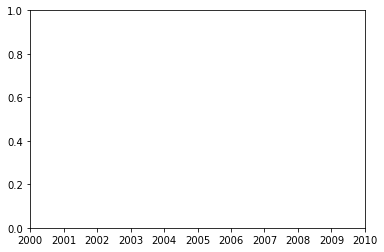

In [254]:
x_fixed_features = ["scaled_latitude", "scaled_longitude"]
site_codes = df["code"].unique()
save_path = f"GPR_figures/{filename}/"
plot_model(model, train_df, test_df, x_fixed_features, train_x_features, train_y_features, site_codes, save_path=save_path)

In [ ]:
"""
LOAD MODEL
"""

In [ ]:
"""
TRANSFORM SAVED MODELS TO FIT THIS NEW WORKFLOW
"""
filename = "2679_NO2_D_09012020_12312020"
df = pickle.load(open(f"{filename}_df.sav", "rb"))

df = df.sort_values("date")
dates = df["date"].values

t = -1
current_date = None
time_steps = []
for date in dates:
    if date != current_date:
        t += 1
        current_date = date
    time_steps.append(t)
df["t"] = time_steps

df = df.rename(columns={'norm_lat': 'scaled_latitude', 'norm_lon': 'scaled_longitude'})
    
model = pickle.load(open(f"{filename}_model.sav", "rb"))
train_indices, test_indices = pickle.load(open(f"{filename}_indices.sav", "rb"))
train_scalers = pickle.load(open(f"{filename}_scalers.sav", "rb"))
site_codes = df["code"].unique()
train_df, test_df = df.iloc[train_indices, :], df.iloc[test_indices, :]